# Stock Price Prediction (NIFTY 50)

This project focuses on predicting **NIFTY 50 stock prices** using both **Machine Learning (ML)** and **Deep Learning (DL)** approaches.  
The workflow involves preparing time-series data, training multiple models, and comparing their performance.

---

## Pipeline Overview

1. **Data Loading**
   - Load stock price data (`data.csv`).
   - Features: `High`.

2. **Data Preparation**
   - Create supervised learning datasets using sliding windows (30–250 days).
   - Generate `(X, y)` pairs for each feature.

3. **Modeling**
   - **Machine Learning Models**   
     - Others:  `KNN`
   - **Deep Learning Models**  
     - RNN, LSTM, GRU, Bidirectional LSTM (Keras Sequential API)

4. **Training**
   - Train models on rolling window datasets.
   - Evaluate using **MAE** and **RMSE**.

5. **Evaluation & Comparison**
   - Store results for all models.
   - Compare ML vs DL models for different input window sizes.

---

## Key Highlights
- Hybrid pipeline combining **classical ML** and **neural networks**.  
- Uses **multiple time horizons (30–250 days)** for robust prediction.  
- Tracks **training and testing errors** to evaluate generalization.  

In [1]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/data/MyDrive/Datasets/data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


In [3]:
def return_high(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns =  ['High']
day_chunks =  [30,60, 90]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_high(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_high = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_high.append([key, y_key])

In [4]:
chunked_data['X_High_90'].shape

(6225, 90)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
ml_models = [
    ("KNN", KNeighborsRegressor())
]
dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

In [7]:
trained_models = {}

for X, y in tqdm(chunk_high):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [8]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head()

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_High_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_High_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,RNN_High_30,"<Sequential name=sequential, built=True>",6387.483522,8841.389334,5890.400023,8444.961824
6,RNN_High_60,"<Sequential name=sequential_4, built=True>",6418.684383,8877.647236,5963.301136,8380.231843


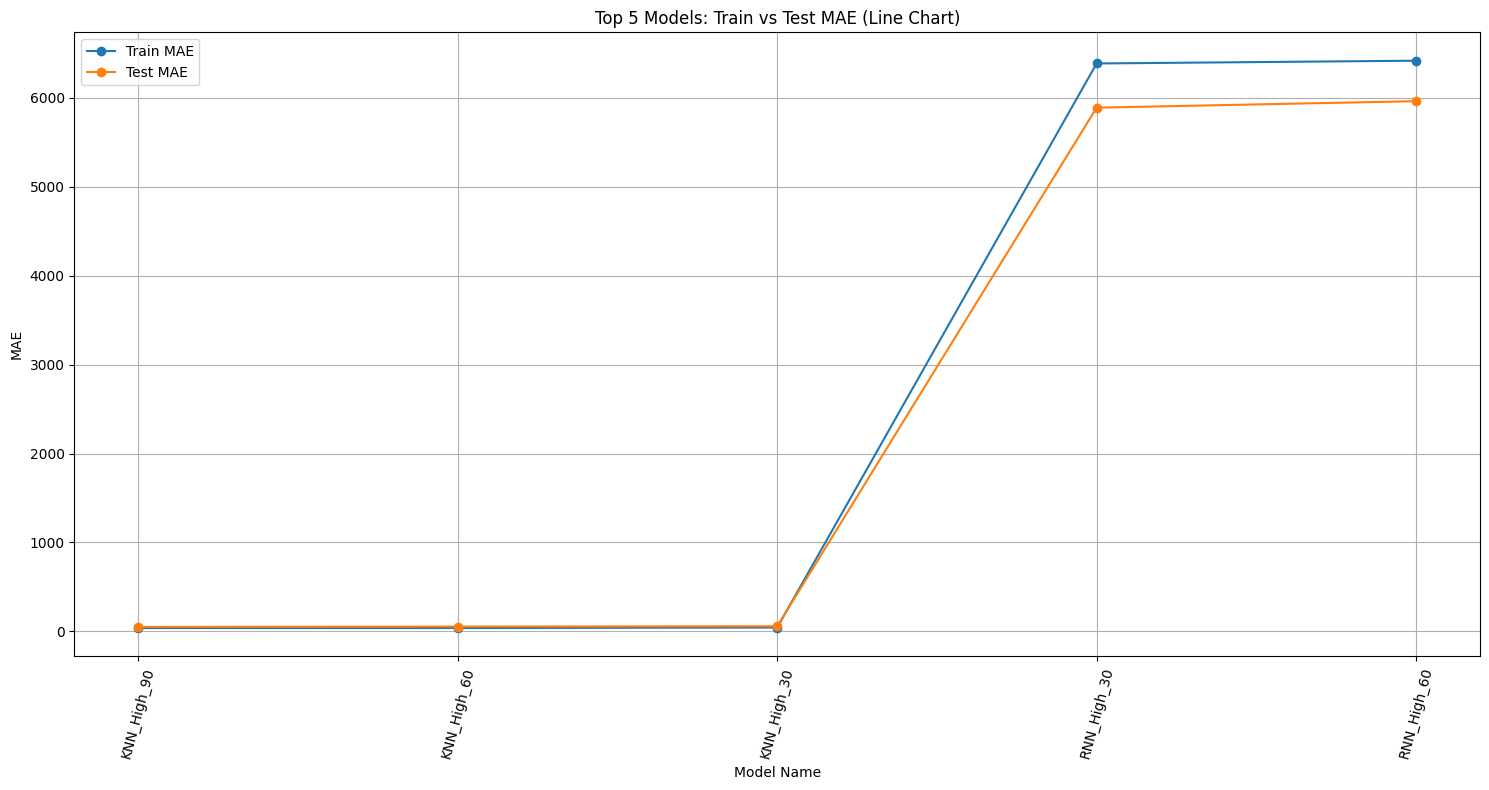

In [11]:
import matplotlib.pyplot as plt


top_5 = results_df.sort_values(by='test_mae', ascending=True).head()

plt.figure(figsize=(15, 8))
plt.plot(top_5['Model'], top_5['train_mae'], marker='o', label='Train MAE')

plt.plot(top_5['Model'], top_5['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 5 Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

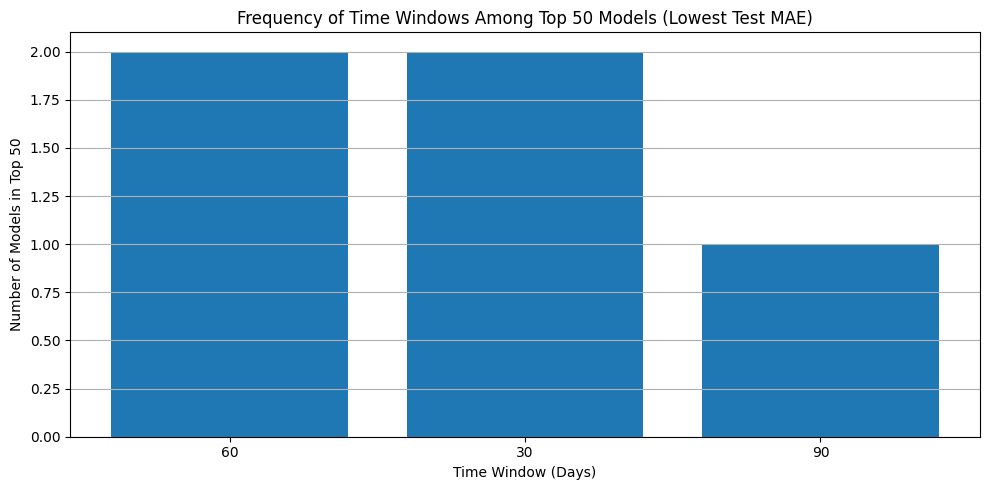

In [12]:
top_5 = results_df.sort_values(by='test_mae', ascending=True).head()
time_windows = pd.Series([i.split('_')[-1] for i in top_5['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

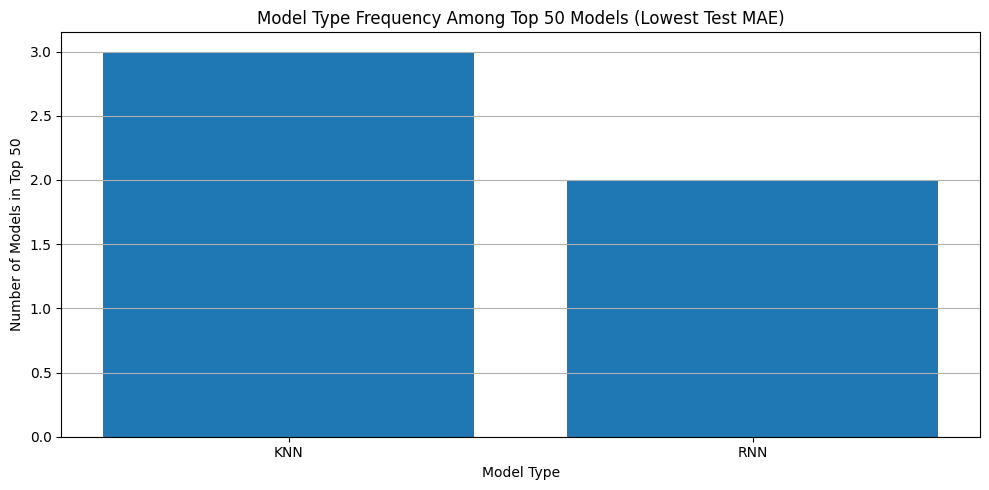

In [13]:
top_5 = results_df.sort_values(by='test_mae', ascending=True).head()
model_types = pd.Series([i.split('_')[0] for i in top_5['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [14]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

In [15]:
loaded_models['KNN_High_90']
model = loaded_models['KNN_High_90']['model']

In [16]:
print(chunked_data['X_High_90'][5])
print(model.predict([chunked_data['X_High_90'][5]]))

[1662.1  1639.9  1631.55 1671.15 1627.4  1668.45 1615.15 1644.45 1644.4
 1626.5  1645.   1613.65 1633.55 1610.9  1598.35 1554.15 1605.9  1616.7
 1621.35 1645.9  1676.1  1731.65 1713.7  1771.65 1795.45 1744.5  1742.8
 1753.1  1764.15 1767.8  1781.05 1818.15 1751.6  1757.05 1726.65 1783.3
 1727.9  1773.85 1719.15 1721.   1730.85 1765.25 1692.25 1680.45 1645.
 1571.3  1630.95 1621.2  1585.25 1604.   1629.2  1579.4  1593.3  1575.85
 1609.4  1557.85 1545.55 1555.5  1534.05 1467.4  1475.25 1558.05 1636.95
 1631.6  1628.55 1587.95 1518.55 1478.85 1469.05 1425.55 1431.8  1383.8
 1439.05 1455.85 1438.   1421.5  1342.15 1385.15 1428.6  1436.6  1385.7
 1391.35 1359.1  1326.3  1311.7  1310.45 1347.7  1316.2  1293.45 1267.85]
[1261.65]
